In [38]:
import os
import glob

In [39]:
from torch_snippets import *
IMAGE_ROOT = 'C:/Users/rd238422/ObjectDetection/dataset/images/images/'
DF_RAW =df= pd.read_csv('C:/Users/rd238422/ObjectDetection/dataset/df.csv')
DF_RAW.head()
d = DF_RAW[DF_RAW['ImageID']=="0000599864fd15b3"]
d=d[['XMin','YMin','XMax','YMax']]
print(d)
de = d[['XMin','YMin','XMax','YMax']].values
de[:,[0,2]]*224

      XMin      YMin     XMax      YMax
0  0.34375  0.156162  0.90875  0.650047


array([[ 77.  , 203.56]])

In [15]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
target2label = {t:l for l,t in label2target.items()}
label2target['background'] = 0
background_class = label2target['background']
num_classes = len(label2target)

In [17]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [34]:
class OpenDataset(torch.utils.data.Dataset):
    w,h = 224,224
    def __init__(self,df,image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df['ImageID'].unique()
    
    def __getitem__(self,ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id,self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w,self.h),resample=Image.BILINEAR))/255. #Bilinear Filtering
        data = df[df['ImageID']==image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        # Absolute Coordinates
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        # torch FRCNN expects ground truths as a 
        # dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_img(img)
        return img, target
    
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_infos)

In [43]:
from sklearn.model_selection import train_test_split
trn_ids,val_ids = train_test_split(df.ImageID.unique(),test_size=0.1,random_state=99)

trn_df,val_df = df[df['ImageID'].isin(trn_ids)],df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4,collate_fn=test_ds.collate_fn,drop_last=True)

In [50]:
# Define the model

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_preditor = FastRCNNPredictor(in_features,num_classes)
    return model

In [53]:
get_model()

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [48]:
!pip install torchsummary

In [55]:
#define training and validation function

def train_batch(inputs,model,optimizer):
    model.train()
    input,targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input,targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() 
def validate_batch(inputs, model):
    model.train() 
#to obtain losses, model needs to be in train mode only
#Note that here we arn't defining the model's forward method 
#hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v \
                in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [56]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, \
                            momentum=0.9,weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), \
                 trn_loc_loss=loc_loss.item(), \
                 trn_regr_loss=regr_loss.item(), \
                 trn_objectness_loss=loss_objectness.item(), \
               trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), \
                 end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), \
                 val_loc_loss=loc_loss.item(), \
                 val_regr_loss=regr_loss.item(), \
                val_objectness_loss=loss_objectness.item(), \
               val_rpn_box_reg_loss=loss_rpn_box_reg.item(), \
                 end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000  trn_regr_loss: 0.080  val_objectness_loss: 0.014  val_loc_loss: 0.068  trn_loss: 0.182  trn_rpn_box_reg_loss: 0.008  val_regr_loss: 0.078  trn_loc_loss: 0.076  trn_objectness_loss: 0.017  val_rpn_box_reg_loss: 0.009  val_loss: 0.170  (975.66s - 3902.65s remaining)
EPOCH: 2.000  trn_regr_loss: 0.074  val_objectness_loss: 0.014  val_loc_loss: 0.074  trn_loss: 0.155  trn_rpn_box_reg_loss: 0.007  val_regr_loss: 0.079  trn_loc_loss: 0.064  trn_objectness_loss: 0.010  val_rpn_box_reg_loss: 0.009  val_loss: 0.175  (1747.12s - 2620.69s remaining)
EPOCH: 3.000  trn_regr_loss: 0.071  val_objectness_loss: 0.015  val_loc_loss: 0.071  trn_loss: 0.144  trn_rpn_box_reg_loss: 0.007  val_regr_loss: 0.081  trn_loc_loss: 0.059  trn_objectness_loss: 0.008  val_rpn_box_reg_loss: 0.009  val_loss: 0.176  (2668.67s - 1779.11s remaining)
EPOCH: 4.000  trn_regr_loss: 0.069  val_objectness_loss: 0.016  val_loc_loss: 0.078  trn_loss: 0.140  trn_rpn_box_reg_loss: 0.007  val_regr_loss: 0.081  trn_loc_

100%|███████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 318.61it/s]


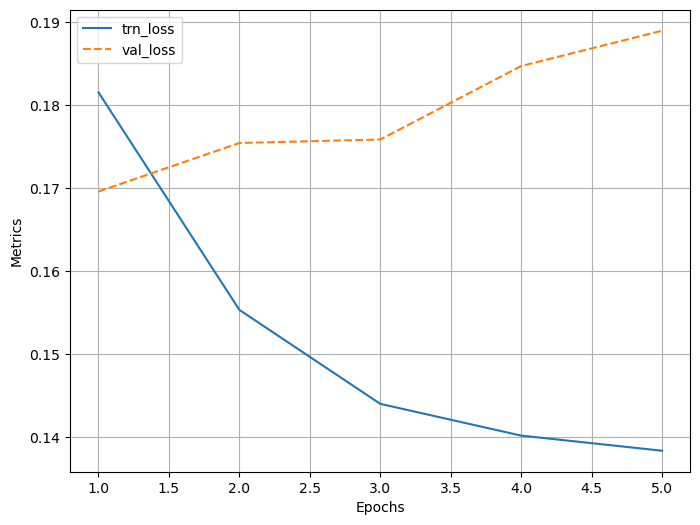

In [58]:
log.plot_epochs(['trn_loss','val_loss'])

In [61]:
from torchvision.ops import nms
# output of the pretrained model contains boxes, labels and scores
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = \
    output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in \
                output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), 
                            torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, \
                                            confs, labels]]

    if len(ixs) == 1:
        bbs,confs,labels = [np.array([tensor]) for tensor \
                                in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


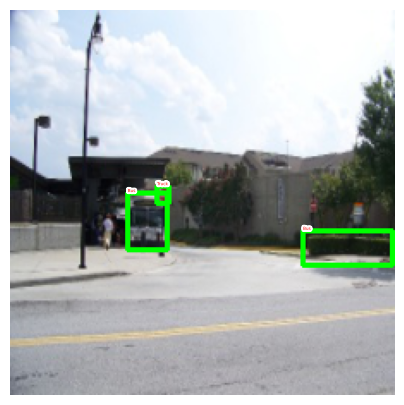

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


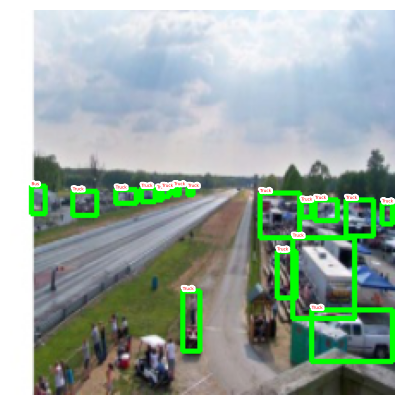

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


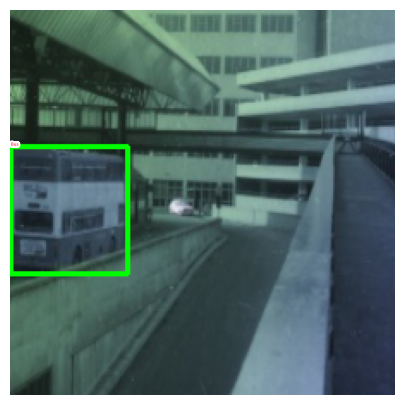

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


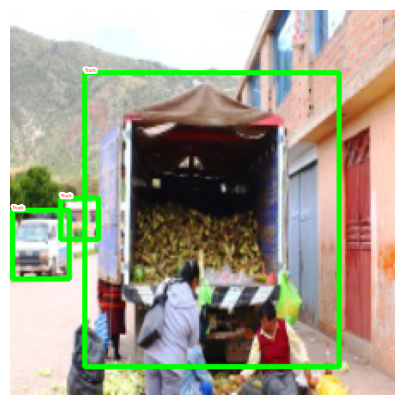

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


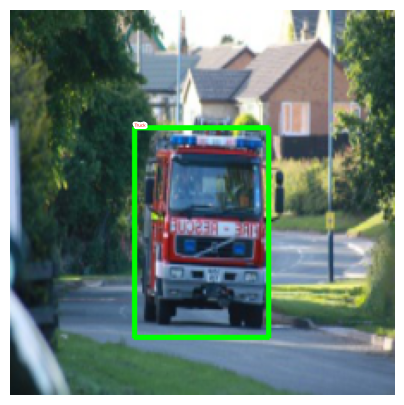

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


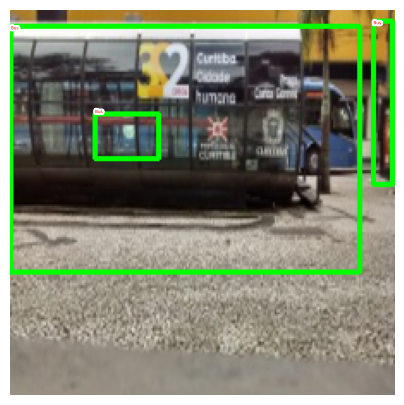

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


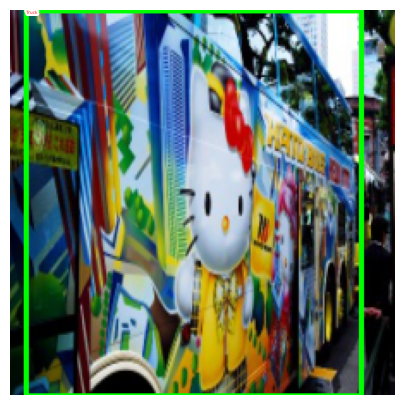

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


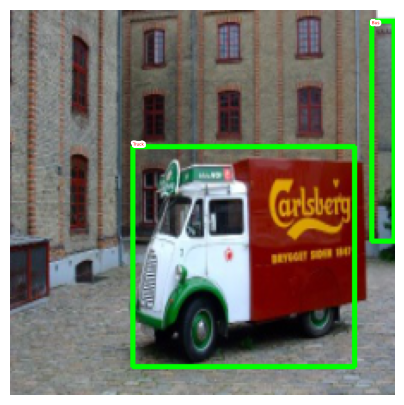

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


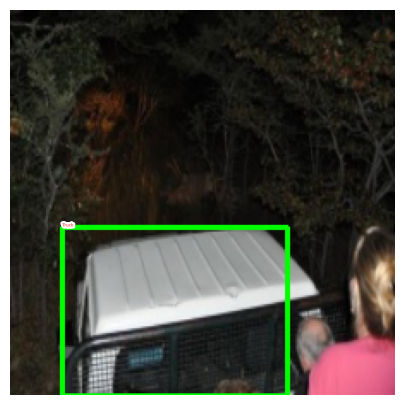

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


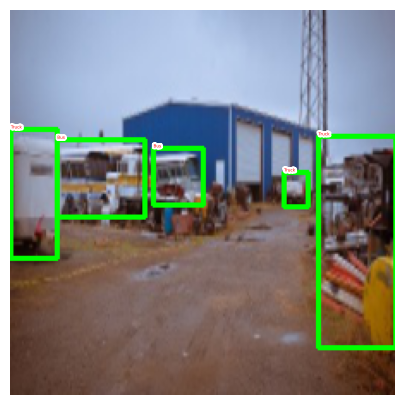

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


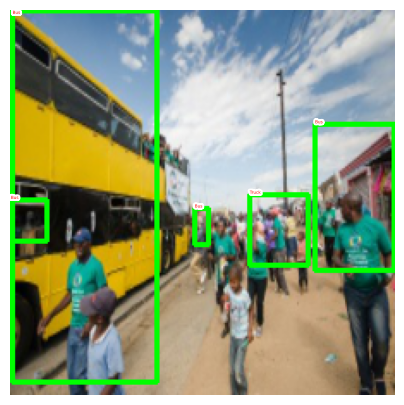

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


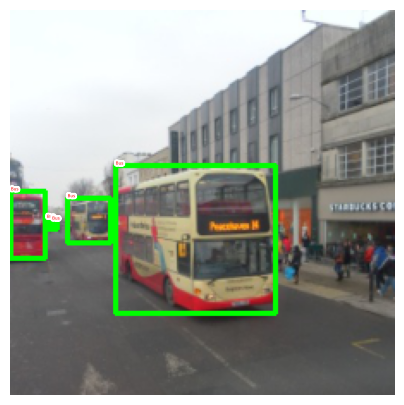

In [62]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, \
                texts=labels, sz=5)